In [65]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
plt.style.use('ggplot')
%matplotlib inline

In [66]:
def load_data(path):
    '''
    Loads data from the given path

    Parameters
    ----------
    path: str

    Returns
    -------
    train_data: np.array, shape = (N, 12), N=number of train data points
    test_data:  np.array, shape = (M, 12), M=number of test data points
    Each data points contains the 4 sensor readings for 3 consecutive frames
    The test_data and train_data are mutually exclusive and properly shuffled
    '''
    data = np.genfromtxt(path, delimiter=" ")[:, :4]
    
    # Reshape so each row contains sensor readings for 3 consecutive frames
    data = data.reshape(-1,4*3)

    # Shuffle the data
    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)
    data = data[idx]

    # Split into training and testing
    train_ratio = 0.7
    n_train = int(data.shape[0]*train_ratio)
    train_data = data[:n_train]
    test_data = data[n_train:]
    return train_data, test_data

def add_noise(test_data, bias, variance):
    '''
    Adds noise to given sensor readings

    Parameters
    ----------

    Returns
    -------
    
    '''
    # Add noise to half of the test_data
    n_corrupt = int(0.5*test_data.shape[0])
    test_data = np.copy(test_data)
    test_data[n_corrupt:] += np.random.normal(bias,variance,test_data[n_corrupt:].shape)

    # Create test_labels
    test_labels = np.zeros(test_data.shape[0])
    test_labels[n_corrupt:] = 1

    return test_data, test_labels

def draw_roc_curve(preds, labels, thresholds, title):
    fpr = []
    tpr = []
    for t in thresholds:
        class_preds = preds<t
        tn, fp, fn, tp = confusion_matrix(labels, class_preds).ravel()
        fpr.append(fp/(fp+tn))
        tpr.append(tp/(tp+fn))
    
    # Draw ROC curve
    plt.title(title)
    plt.plot(fpr, tpr)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()

class AnomalyDetector:
    def __init__(self, n_components, train_data, threshold=0):
        self.gm = GaussianMixture(n_components=n_components).fit(train_data)
        self.threshold = threshold
    
    def anomaly_prob(self, x):
        return self.gm.score_samples(x)

    def is_anomaly(self, x):
        preds = self.gm.score_samples(x)<self.threshold
        return preds.astype(int)
    
    def evaluate(self, data, labels):
        preds = self.is_anomaly(data)
        return np.mean(preds==labels)


train_data, test_data = load_data('data_gen_1.txt')
model = AnomalyDetector(5, train_data)

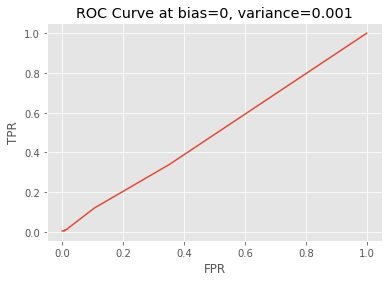

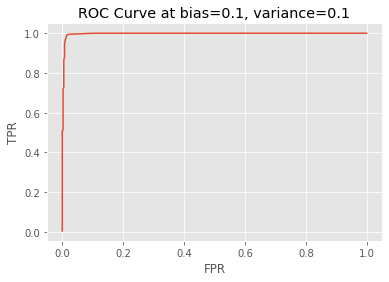

In [67]:
# Sanity check, adding almost no noise -> should get a linear ROC curve
test_data_noise, test_labels = add_noise(test_data, bias=0.0, variance=0.001)
draw_roc_curve(model.anomaly_prob(test_data_noise), test_labels, np.arange(-1e4,200,10), "ROC Curve at bias=0, variance=0.001")

# Adding noise that should be better detected
test_data_noise, test_labels = add_noise(test_data, bias=0.1, variance=0.1)
draw_roc_curve(model.anomaly_prob(test_data_noise), test_labels, np.arange(-1e4,200,10), "ROC Curve at bias=0.1, variance=0.1")

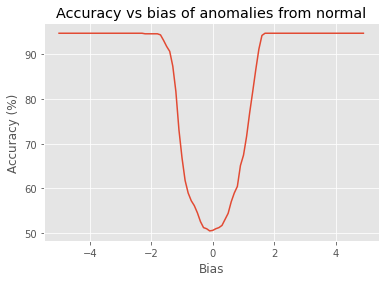

In [68]:
# Plotting accuracy vs bias, variance = 0.001
accuracies = []
biases = np.arange(-5,5,0.1)

for bias in biases:
    test_data_noise, test_labels = add_noise(test_data, bias=bias, variance=0.001)
    acc = np.mean(test_labels == model.is_anomaly(test_data_noise))
    accuracies.append(acc*100)

plt.title("Accuracy vs bias of anomalies from normal")
plt.plot(biases, accuracies)
plt.xlabel("Bias")
plt.ylabel("Accuracy (%)")
plt.show()